# 03_model_training (Fixed)
This notebook trains baseline regression models for Grammar MOS prediction using extracted audio features.

**Fixes included:**
- Handles `Unnamed: 0` column from CSV saves.
- Normalizes filenames (strip + ensure `.wav`) on both features and labels.
- Merges features with labels reliably.
- Cleans NaN/Inf values (median imputation) to avoid training failures.
- Uses competition metrics: RMSE and Pearson correlation.


In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")


## 1. Path Configuration
Adjust these paths only if your folder structure differs.


In [16]:
# Base raw data directory (notebooks → ../data/raw)
DATA_DIR = os.path.join("..", "data", "raw")

# CSV paths
TRAIN_CSV = os.path.join(DATA_DIR, "csvs", "train.csv")
TEST_CSV  = os.path.join(DATA_DIR, "csvs", "test.csv")

# Audio directories (not used in this notebook, but kept for consistency)
TRAIN_AUDIO_DIR = os.path.join(DATA_DIR, "audios", "train")
TEST_AUDIO_DIR  = os.path.join(DATA_DIR, "audios", "test")

# Feature file (created in Day 2)
FEATURES_CSV = os.path.join("..", "data", "processed", "train_audio_features.csv")

print("TRAIN_CSV:", TRAIN_CSV)
print("FEATURES_CSV:", FEATURES_CSV)

print("Train CSV exists:", os.path.exists(TRAIN_CSV))
print("Features CSV exists:", os.path.exists(FEATURES_CSV))


TRAIN_CSV: ..\data\raw\csvs\train.csv
FEATURES_CSV: ..\data\processed\train_audio_features.csv
Train CSV exists: True
Features CSV exists: True


## 2. Load Features & Labels
We load the extracted feature CSV and the training label CSV.


In [17]:

features_df = pd.read_csv(FEATURES_CSV)
train_df = pd.read_csv(TRAIN_CSV)

print("Features shape (raw load):", features_df.shape)
print("Train CSV shape:", train_df.shape)

print("\nFeatures columns (first 8):", features_df.columns.tolist()[:8])
print("Train columns:", train_df.columns.tolist())


Features shape (raw load): (276, 35)
Train CSV shape: (409, 2)

Features columns (first 8): ['filename', 'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6']
Train columns: ['filename', 'label']


## 3. Clean Feature CSV Artifacts
If the features CSV was saved with an index, Pandas may load it as `Unnamed: 0`.


In [18]:
if "Unnamed: 0" in features_df.columns:
    features_df = features_df.drop(columns=["Unnamed: 0"])

print("Features shape (after drop Unnamed: 0 if any):", features_df.shape)


Features shape (after drop Unnamed: 0 if any): (276, 35)


## 4. Normalize Filenames on Both Sides
To ensure the merge works, we strip whitespace and ensure `.wav` is present for both features and labels.


In [19]:
# Ensure filename columns exist
if "filename" not in features_df.columns:
    raise KeyError("features_df does not contain 'filename' column. Fix 02_feature_extraction to include filename.")

if "filename" not in train_df.columns:
    raise KeyError("train_df does not contain 'filename' column. Check your train.csv header.")

# Normalize: strip spaces
features_df["filename"] = features_df["filename"].astype(str).str.strip()
train_df["filename"] = train_df["filename"].astype(str).str.strip()

# Normalize: ensure .wav extension on both
features_df["filename"] = features_df["filename"].apply(lambda x: x if x.endswith(".wav") else x + ".wav")
train_df["filename"]    = train_df["filename"].apply(lambda x: x if x.endswith(".wav") else x + ".wav")

print("Example feature filenames:", features_df["filename"].head().tolist())
print("Example train filenames:", train_df["filename"].head().tolist())


Example feature filenames: ['audio_127.wav', 'audio_34.wav', 'audio_120_2.wav', 'audio_224.wav', 'audio_342.wav']
Example train filenames: ['audio_173.wav', 'audio_138.wav', 'audio_127.wav', 'audio_95.wav', 'audio_73.wav']


## 5. Debug Overlap + Merge
If overlap is 0, filenames differ (extensions, casing, extra characters). The debug output shows examples.


In [20]:
feat_set = set(features_df["filename"])
train_set = set(train_df["filename"])

print("Unique feature files:", len(feat_set))
print("Unique train files:", len(train_set))
print("Common files:", len(feat_set & train_set))

print("\nExamples only in features:", list(feat_set - train_set)[:5])
print("Examples only in train:", list(train_set - feat_set)[:5])

merged_df = features_df.merge(train_df, on="filename", how="inner")
print("\nMerged shape:", merged_df.shape)


Unique feature files: 276
Unique train files: 409
Common files: 276

Examples only in features: []
Examples only in train: ['audio_258.wav', 'audio_296.wav', 'audio_278.wav', 'audio_185.wav', 'audio_247.wav']

Merged shape: (276, 36)


## 6. Handle Label Column Name
Some datasets use `score`, others use `label`. We support both.


In [21]:
# Determine label column name
label_col = None
for candidate in ["score", "label"]:
    if candidate in merged_df.columns:
        label_col = candidate
        break

if label_col is None:
    raise KeyError("No label column found. Expected 'score' or 'label' in train.csv.")

print("Using label column:", label_col)


Using label column: label


## 7. Clean NaN/Inf in Features
We median-impute missing values to keep training stable.


In [22]:
# Separate feature columns
feature_cols = [c for c in merged_df.columns if c not in ["filename", label_col]]

# Replace inf with NaN
merged_df[feature_cols] = merged_df[feature_cols].replace([np.inf, -np.inf], np.nan)

# Report missingness
nan_counts = merged_df[feature_cols].isna().sum().sort_values(ascending=False)
print("Top columns with NaNs (if any):")
print(nan_counts.head(10))

# Median imputation
for col in feature_cols:
    if merged_df[col].isna().any():
        merged_df[col] = merged_df[col].fillna(merged_df[col].median())

# Confirm cleaned
print("\nAny NaNs left in features?", merged_df[feature_cols].isna().any().any())


Top columns with NaNs (if any):
mfcc_0    0
mfcc_1    0
mfcc_2    0
mfcc_3    0
mfcc_4    0
mfcc_5    0
mfcc_6    0
mfcc_7    0
mfcc_8    0
mfcc_9    0
dtype: int64

Any NaNs left in features? False


## 8. Train–Validation Split


In [23]:
X = merged_df[feature_cols]
y = merged_df[label_col]

print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train samples:", X_train.shape[0], " | Val samples:", X_val.shape[0])


X shape: (276, 34)
y shape: (276,)
Train samples: 220  | Val samples: 56


## 9. Baseline Model: Ridge Regression
A strong, simple baseline with scaling.


In [24]:
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_val)

mse = mean_squared_error(y_val, pred_ridge)
rmse_ridge = np.sqrt(mse)

pearson_ridge = pearsonr(y_val, pred_ridge)[0]

print("Ridge RMSE:", round(rmse_ridge, 4))
print("Ridge Pearson:", round(pearson_ridge, 4))


Ridge RMSE: 0.66
Ridge Pearson: 0.3886


### Ridge: Prediction Plot


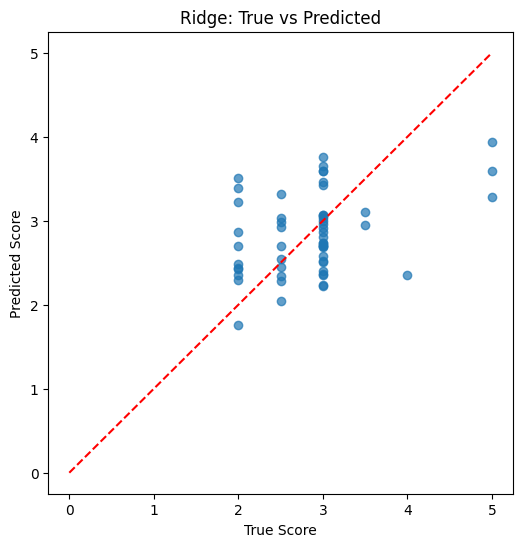

In [25]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, pred_ridge, alpha=0.7)
plt.plot([0, 5], [0, 5], "r--")
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.title("Ridge: True vs Predicted")
plt.show()


## 10. Non-linear Model: Random Forest
Captures non-linear patterns; can overfit on small data, so treat as an experiment.


In [26]:
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_val)

mse_rf = mean_squared_error(y_val, pred_rf)
rmse_rf = np.sqrt(mse_rf)
pearson_rf = pearsonr(y_val, pred_rf)[0]

print("RF RMSE:", round(rmse_rf, 4))
print("RF Pearson:", round(pearson_rf, 4))

RF RMSE: 0.6499
RF Pearson: 0.3397


### Random Forest: Prediction Plot


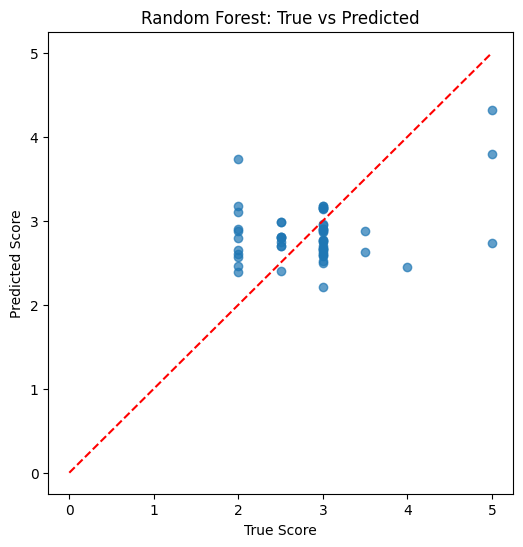

In [27]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, pred_rf, alpha=0.7)
plt.plot([0, 5], [0, 5], "r--")
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.title("Random Forest: True vs Predicted")
plt.show()


## 11. Model Comparison


In [28]:
results = pd.DataFrame({
    "Model": ["Ridge", "Random Forest"],
    "RMSE": [rmse_ridge, rmse_rf],
    "Pearson": [pearson_ridge, pearson_rf]
})
results


,Model,RMSE,Pearson
0,Ridge,0.660045,0.388602
1,Random Forest,0.649883,0.339737


## 12. Saving Variables

In [29]:
val_results = pd.DataFrame({
    "true_score": y_val,
    "pred_score": pred_ridge  
})

SAVE_PRED_PATH = os.path.join("..", "data", "processed", "val_predictions.csv")
val_results.to_csv(SAVE_PRED_PATH, index=False)

print("Saved validation predictions to:", SAVE_PRED_PATH)

Saved validation predictions to: ..\data\processed\val_predictions.csv


## Notes
- If `Merged shape` is still `(0, …)`, inspect the filename examples printed in Section 5.
- Ensure your `02_feature_extraction.ipynb` saves `filename` values matching `train.csv` (same extension and naming).
